In [1]:
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
def generate_data(num_observation = 200, num_features = 9):
    beta_true = np.array(
        [-1, 1, -1, 1, -1, 1, -1, 1, -1, 1]
    ) #(10, )
    X_0 = np.ones(num_observation).reshape(-1, 1)
    X = np.random.normal(
        size = (num_observation, num_features)
    )
    X = np.concatenate(
        [X_0, X], axis = 1
    ) #(200, 10)
    z = np.dot(X, beta_true)
    logit = np.exp(z) / (1 + np.exp(z))
    y = np.random.binomial(1, logit)
    return X, y

## Plot1

In [3]:
class HandCraftLogisticRegression:
    def __init__(self, X, y):
        self.X = X.copy()
        self.y = y.copy()
        self.grad_record = []
        self.loss_record = []

    def solve(self, max_iter, step, tol):
        w = self.initialize_params()
        loss = 10 ** 5
        num_iter = 0
        batch_size = 10

        #adagrad
        eps = 1e-12
        g_w = np.ones(self.X.shape[1])

        while num_iter < max_iter and loss > tol:
            #Shuffle when each epoch begin
            index = np.arange(self.X.shape[0])
            np.random.shuffle(index)
            X = self.X[index]
            y = self.y[index]
            for num_batch in range(int(self.X.shape[0] / batch_size)):
                x_batch = X[num_batch * batch_size:(num_batch + 1) * batch_size]
                y_batch = y[num_batch * batch_size:(num_batch + 1) * batch_size]

                #implement adagrad
                w_grad = self.compute_gradient(x_batch, y_batch, w)
                g_w += w_grad ** 2

                w = w - step * w_grad / np.sqrt(g_w + eps)


            w_grad_norm = np.linalg.norm(self.compute_gradient(X, y, w), ord = 2)
            self.grad_record.append(w_grad_norm)

            #compute loss
            y_pred = self.compute_logistic_value(self.X, w)
            loss = self.compute_cross_entropy_loss(y_pred, self.y)
            self.loss_record.append(loss)
            acc = self.compute_accuracy(y_pred, self.y)
            print(f"Iteration {num_iter + 1}, BCE loss: {loss}, Acc: {round(acc, 4)}, Grad norm: {w_grad_norm}")
            num_iter += 1

    def initialize_params(self):
        w = np.random.rand(self.X.shape[1])
        return w

    def compute_gradient(self, X, y_true, w):
        #print(w.shape)
        y_pred = self.compute_logistic_value(X, w).flatten() #dim = (batch_size, )
        pred_error = y_true - y_pred
        w_grad = -np.dot(X.T, pred_error) #dim = (feature_size, )
        return w_grad

    def compute_logistic_value(self, X, w):
        return self.sigmoid(np.matmul(X, w))

    def compute_cross_entropy_loss(self, y_pred, y_true):
        eps = 1e-12
        y_pred = np.clip(y_pred, eps, 1-eps)
        cross_entropy = -np.dot(y_true, np.log(y_pred)) - np.dot((1-y_true), np.log(1 - y_pred))
        return cross_entropy

    def compute_accuracy(self, y_pred, y_true):
        accuracy = 1 - np.mean(np.abs(y_pred - y_true))
        return accuracy

    def sigmoid(self, z):
        res = 1 / (1.0 + np.exp(-z))
        return np.clip(res, 1e-6, 1 - (1e-6))

In [4]:
X, y = generate_data()
max_iter = 10000
tol = 5 * (10 ** -6)
gram_maitrx = np.dot(X, X.T) / X.shape[0]
eig_values, eig_vectors = np.linalg.eig(gram_maitrx)
step_size = max(eig_values).real
#step_size = 0.05
LR = HandCraftLogisticRegression(X, y)
LR.solve(max_iter, step_size, tol)

Iteration 1, BCE loss: 67.84860269568543, Acc: 0.8206, Grad norm: 17.402861392425912
Iteration 2, BCE loss: 62.23237492037791, Acc: 0.8168, Grad norm: 12.188373384906829
Iteration 3, BCE loss: 61.265057325292396, Acc: 0.8158, Grad norm: 10.793162914176648
Iteration 4, BCE loss: 59.774445112799214, Acc: 0.8226, Grad norm: 8.50267705685398
Iteration 5, BCE loss: 60.64346812027409, Acc: 0.8257, Grad norm: 9.81128318327609
Iteration 6, BCE loss: 59.10033731668683, Acc: 0.8195, Grad norm: 7.065834962859622
Iteration 7, BCE loss: 59.13340525775293, Acc: 0.8168, Grad norm: 6.900311387191687
Iteration 8, BCE loss: 60.076900472084496, Acc: 0.828, Grad norm: 8.856589092116712
Iteration 9, BCE loss: 59.879564352696335, Acc: 0.8208, Grad norm: 8.811372546134075
Iteration 10, BCE loss: 59.10852090245559, Acc: 0.8233, Grad norm: 6.798787207808598
Iteration 11, BCE loss: 58.699365272063986, Acc: 0.8239, Grad norm: 5.645900905115701
Iteration 12, BCE loss: 59.06795011717581, Acc: 0.822, Grad norm: 6.7

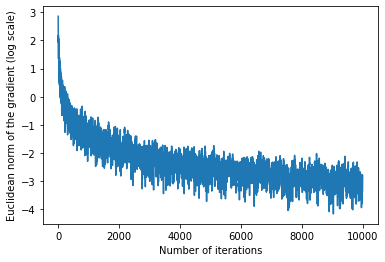

In [5]:
loss_handcraft = LR.loss_record
grad_norm = LR.grad_record
_xaxis = np.arange(max_iter)
plt.ylabel("Euclidean norm of the gradient (log scale)")
plt.xlabel("Number of iterations")
plt.plot(_xaxis, np.log(grad_norm))
plt.show()

# Plot2

In [6]:
gc.collect()
def compute_cross_entropy_loss(y_pred, y_true):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1-eps)
    cross_entropy = -np.dot(y_true, np.log(y_pred)) - np.dot((1-y_true), np.log(1 - y_pred))
    return cross_entropy

In [7]:
LR_sklearn = LogisticRegression(penalty="none", max_iter = max_iter, tol = tol)
LR_sklearn.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs',
                   tol=4.9999999999999996e-06, verbose=0, warm_start=False)

In [8]:
y_pred_sklearn = LR_sklearn.predict_proba(X)
theoretical_loss = compute_cross_entropy_loss(y_pred_sklearn[:, 1], y)

In [9]:
theoretical_loss_max_iter = np.repeat(theoretical_loss, max_iter)
loss_diff = np.array(loss_handcraft) - theoretical_loss

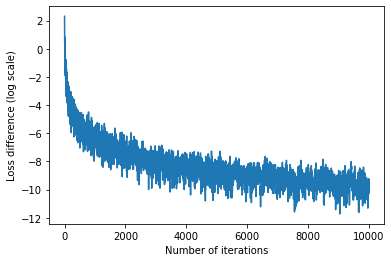

In [10]:
plt.ylabel("Loss difference (log scale)")
plt.xlabel("Number of iterations")
plt.plot(_xaxis, np.log(loss_diff))
plt.show()